# 1.0 Generating datasets

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, auc, f1_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time


RANDOM_STATE = 254687
N_SAMPLES = 2587
N_FEATURES = 2
N_CLASSES = 2


class SyntheticDataset:
    """A class to generate and preprocess synthetic datasets for classification task."""

    def __init__(self, random_state: int, n_samples: int, n_features: int, n_classes: int, n_informative: int = N_FEATURES, n_clusters_per_class: int = 1, class_sep: float = 1):
        """
        Initialize the SyntheticDataset class.

        :param random_state: Seed for random number generation.
        :param n_samples: Number of samples to generate.
        :param n_features: Number of features for the dataset.
        :param n_classess: Number of classes for the target variable.
        """
        self.random_state = random_state
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_clusters_per_class = n_clusters_per_class
        self.class_sep = class_sep
        self.n_informative = n_informative
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None


    def generate_make_classification(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Generate a synthetic dataset using make_classification
        
        :return: A tuple containing the feature matrix (X) and target vector (y)
        """
        self.X, self.y = make_classification(
            n_samples=self.n_samples,
            n_features=self.n_features,
            n_informative=self.n_informative,
            n_redundant=0,
            n_clusters_per_class=self.n_clusters_per_class, # single-mod means one cluster per class
            random_state=self.random_state,
            class_sep=self.class_sep
            
        )
        return self.X, self.y
    
    def generate_make_moons(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Generate a synthetic dataset using make_mmons

        :return: A tuple containing the feature matrix (X) and target vector (y)
        """
        self.X, self.y = make_moons(
            n_samples=self.n_samples,
            random_state=self.random_state,
        )
        return self.X, self.y

    def normalize(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Normalize the feature matrix (X) and target vector(y) to the range [0,1].

        :return: A tuple containing the normalized feature matrix (X) and target vector (y)
 
        Note: 
        Remmber to fit only on training dataset so it means that I use min and max scaler on training dataset and
        then aplly this boudaries for test dataset. 
               """
        if self.X_train is not None and self.X_test is not None:
            min_x, max_x = self.X_train.min(), self.X_train.max() # Min, max taking only from training dataset
            self.X_train = (self.X_train - min_x) / (max_x - min_x)
            self.X_test = (self.X_test - min_x) / (max_x - min_x)

        return self.X_train, self.X_test 


    def visualize(self): 
        """ Visualize the dataset using a scatter plot"""
        if self.X is not None and self.y is not None:
            plt.figure(figsize=(8,6))
            sns.scatterplot(x=self.X[:,0], y=self.X[:,1], hue=self.y)
            plt.title("Synthetic Dataset Visualization")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.show()
        else:
            print("Dataset not generated yet. Call generate() first.")


    
    def splitting(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Function for splitting datasets into training and test"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=RANDOM_STATE)
        return self.X_train, self.X_test, self.y_train, self.y_test

    


    
dataset = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES)
dataset.generate_make_classification() 

# Dividing dataset on a trening set and test set 
dataset.splitting()

# Normalization of datasets 
dataset.normalize()


dataset_moons = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES)
dataset_moons.generate_make_moons() 

# Dividing dataset on a trening set and test set 
dataset_moons.splitting()

# Normalization of datasets 
dataset_moons.normalize()

(array([[0.49411673, 0.62532616],
        [0.00276423, 0.37617232],
        [0.09878011, 0.57017906],
        ...,
        [0.30499921, 0.66546025],
        [0.25701648, 0.65781268],
        [0.74804054, 0.17675179]], shape=(2069, 2)),
 array([[0.58450764, 0.17695046],
        [0.6098477 , 0.17154496],
        [0.95391406, 0.33088452],
        ...,
        [0.15647978, 0.61588233],
        [0.96998429, 0.36176278],
        [0.63793633, 0.46871473]], shape=(518, 2)))

# 2.0 Analyzes

In [158]:
class ResultsAnalyzes:
    """ 
    A class to analyze and visualize the results of a binary classification model.

    Parameters:
        target (np.ndarray): The true labels.
        prediction (np.ndarray): The predicted labels.
    """

    def __init__(self, target: np.ndarray, prediction: np.ndarray):
        self.target = target
        self.prediction = prediction
        self._accuracy = None # Private atribute
        self._sensitivity = None
        self._specificity = None
        self._precision = None
        self._false_match_rate = None
        self._false_non_match_rate = None

    def confusion_matrix(self):
        """ Compute and plot the confusion matrix """
        cm = confusion_matrix(self.target, self.prediction)

        # Plot the confusion matrix using Seaborn
        plt.figure(figsize=(6,4))
        sns.heatmap(
            cm, 
            annot=True, # Displays the value in each cell
            fmt="d", # Format the values as integers
            cmap="Blues", # uses a blue color palette 
            cbar=False, # Hide the color bar
            xticklabels=["Predcited 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"]
        )
        
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion matrix")
        plt.show()

    @property 
    def accuracy(self) -> float:
        """ 
        Compute the accuracy of the predictions.
        
        Notes:
            Tells how many samples were well classified from all samples
        """
        return accuracy_score(self.target, self.prediction) 

    @property
    def sensitivity(self) -> float: 
        """ 
        Compute the sensivitty (recall) of the predictions. Sensitivity (Recall) = TP / (TP + FN) 
        
        Notes:
            Tell how many samples were predicted as True Positive from all Acutal Positive
        """
        
        return recall_score(self.target, self.prediction)

    @property
    def specificity(self) -> float: 
        """
        Compute the specificity of the predictions.  Specificity = TN / (TN + FP)

        Notes:
            Tell how many samples were predicted as True Negatives from all Acutal Negative
        """
        
        cm = confusion_matrix(self.target, self.prediction)
        self.tn, self.fp, self.fn, self.tp = cm.ravel() # ravel function in numpy is used to faltten a multi-dimensional array into a 1-dimensional array. It returns a contiguous flattened array, meaning it 
        # collapses the array into a single dimension while maintaining the order of the elements 
        specificity = self.tn / (self.tn + self.fp)
        return specificity
    
    @property
    def balanced_accuracy(self) -> float:
        """
        Compute class imbalance by giving equal weight to both classes.

        Notes:  
         Useful when:
        - Model detects one class better than the other
        - Dataset has unequal class distribution

        !!!! high BA doesn't reveal if the model beats majority-class guessing
        example: in a 90% majority classs, BA = 0.9 could mean the model just predicts the majority that's why we need J score

        **Interpretation:**  
        - 1 = Perfect classifier  
        - 0.5 = Random guessing  
        
        """
        return (self.sensitivity + self.specificity) / 2
    
    @property
    def j_score(self) -> float:
        """
        Measures how much better the model is than random chance. Penalizes models that rely on class imbalance. 

        Notes:
        baseline = 0 means no better than guessing
        J = 0.6 means the model is 60% better than random
        J = -1 means always wrong
        J = 1 means perfect
        """
        return self.sensitivity + self.specificity - 1
    

    @property
    def f1_score(self) -> float:
        """
        Is a critical metric for evaluating classification models, especially when dealing with imbalanced datasets. 
        Penalizes models that ignore the minority class
        Use case: 
        Ideal for fraud detecion, disease screening:
        * In fraud detection: it answers: "Are we catching enough fraud without overwhelming our team?
        * In disease screening "Are we diagnosing patients early without causing unnecessary panic?
        """
        return f1_score(self.target, self.prediction)
    

    @property
    def false_match_rate(self) -> float:
        """
        This metric is critical in biometric systems (e.g., fingerprint, face recognition) and security applications. 
        Mistaking an impostor for a legitimate user.
        
        Notes:
        Lower FMR → Stricter system (fewer impostors accepted, but more legitimate users rejected).
        A bank vault prioritizes low FMR (avoid impostors) → High FNMR is tolerated (owners may retry).
        """
        return self.fp / (self.fp + self.tn)
    

    @property
    def false_non_match_rate(self) -> float:
        """
        This metric is critical in biometric systems (e.g., fingerprint, face recognition) and security applications. 
        Mistaking a legitimate user for an impostor. \
        
        Notes:
        A office door prioritizes low FNMR (avoid frustrating employees) → Higher FMR risk.       
        """
        return self.fn / (self.fn + self.tp)
    

    def show_results(self):
        """ Display the accuracy, sensitivity and specificity of the predictions"""
        #self.accuracy = self._accuracy()
        #self.sensitivity = self._sensitivity()
        #self.specificity = self._specificity()
        print(f"Accuracy: {self.accuracy:.2f}, Sensivity: {self.sensitivity:.2f}, Specifity: {self.specificity:.2f}")

    
    def plot_ROC_curve(self, y_prediction_probability: np.ndarray):
        """
        Plot the Receiver Operaint Characteristic (ROC) curve.
        
        Parameters:
            y_prediction_probability (np.ndarray): The predicted probabilities for the positive class.
        """
        # Compute ORC curve and AUC
        fpr, tpr, thresholds = roc_curve(self.target, y_prediction_probability) # stands for False Positive Rate (1 - Specificity)  and True Positive Rate (Sensitivity)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC cruve (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characterstics Curve")
        plt.legend(loc="lower right")
        plt.show()

        def plot_decision_boundary(self, X: np.ndarray, y: np.ndarray):
            """
            Plot the decision boundary for a trained model.
            
            Parameters:
                X (np.ndarray): The feature matrix of shape (n_samples,n_features)
                y (np.ndarray): The target vector of shape (n_samples,).
            """

            if X.shape[1] != 2:
                raise ValueError("Decision boundary plotting is only supported for 2D feature spaces.")
            
            # Create a grid of points covering the feature space
            x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1 # Frist feature
            y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1 # Second feature

# 3.0 Implementing neuron

In [159]:
class SingleNeuronModel:
    """
    Implementation of a single neuron model for binary classification 
    
    Parameters:
        learning_rate (float): The learning rate for gradient descent. Default is 0.1
        iterations (int): The maximum number of iterations for gradient descent. Default is 1000.
        error (float): The error threshold for erly stopping. Default is 1e-6
        activation (str): The activation function to use ("logistic", "Heaviside", "sin", "tanh", "sign", "ReLu", "leaky ReLu"). Default is logistic
        leaky_slope (float): Sloep for leaky ReLu's negagative part. Default is 0.01
    """

    def __init__(self, learning_rate: float = 0.1, iterations: int = 1000, error: float = 1e-6, activation: str = "logistic", leaky_slope: float = 0.01):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.error = error
        self.activation = activation
        self.scale_parameter = None # beta in the activation function
        self.weights = None
        self.bias = None
        self.leaky_slope = leaky_slope

    
    def _activation_function(self, s: np.ndarray, scale_parameter: float = 1.0) -> np.ndarray:
        """
        Compute the activation function.
        
        Parameters:
            s (np.ndarray): The input to the activatino function.
            scale_parameter (float): Determines the steepness of the curve. Default is 1.0

        Returns:
            np.ndarray: The output of the activation function.
        """

        self.scale_parameter = scale_parameter
        if self.activation == "logistic":
            return 1 / (1 + np.exp(-self.scale_parameter * s))
        elif self.activation == "Heaviside":
            return (s > 0).astype(float)
        elif self.activation == "sin":
            return np.sin(self.scale_parameter * s)
        elif self.activation == "tanh":
            return np.tanh(self.scale_parameter * s)
        elif self.activation == "sign":
            return np.sign(s)
        elif self.activation == "ReLu":
            return np.maximum(0, s)
        elif self.activation == "leaky ReLu":
            return np.where(s > 0, s, self.leaky_slope * s)
        else:
            raise ValueError(f"Activation function:  {self.activation} not supported")


    def _activation_derivative(self, s: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the activation function
        
        Parameters:
            s (np.ndarray): The input to the activation function
        
        Returns:
            np.ndarray: The derivative of the activation function.
        """
        if self.activation == "logistic":
            sig = self._activation_function(s)
            return self.scale_parameter * sig * (1 - sig)
        elif self.activation == "Heaviside": # Technically derivate is 0 everywhere except at 0, but we assume 0 for practical approach
            return np.zeros_like(s)
        elif self.activation == "sin":
            return self.scale_parameter * np.cos(self.scale_parameter * s)
        elif self.activation == "tanh":
            return self.scale_parameter * (1 - np.tanh(self.scale_parameter * s)**2)
        elif self.activation == "sign": # Technically derivate is 0 everywhere except at 0, but we assume 0 for practical approach
            return np.zeros_like(s)
        elif self.activation == "ReLu":
            return (s > 0).astype(float)
        elif self.activation == "leaky ReLu":
            return np.where(s > 0, 1, self.leaky_slope)
        else:
            raise ValueError(f"Activation function:  {self.activation} not supported")
        

    def _cross_entropy_loss(self, y: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Compute the cross entropy loss.
        
        Parameters:
            y (np.ndarray): The true labels
            y_pred (np.ndarray): The predicted probabilities

        Returns:
            float: The cross-entropy loss.
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Train the single neuron model using gradient descent.

        Parameters:
            X (np.ndarray): The feature matrix of shape (n_samples, n_features)
            y (np.ndarray): The target vector of shape (n_samples)
        """
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples")
        
        # Initialize weights and bias
        self.weights = np.random.randn(X.shape[1]) * 0.01
        self.bias = np.random.randn() * 0.01

        for i in range(self.iterations):
            # Forward pass
            linear_output = np.dot(X, self.weights) + self.bias
            activated_output = self._activation_function(linear_output)

            # Compute error and gradient
            error = activated_output - y

            # Backward pass
            delta = error * self._activation_derivative(linear_output)
            gradient = np.dot(X.T, delta) / len(X)

            # Update parameters
            self.weights -= self.learning_rate * gradient
            self.bias -= self.learning_rate * np.mean(delta)

            # Compute cost
            cost = self._cross_entropy_loss(y, activated_output)

            # Early stopping
            if abs(cost) < self.error:
                print(f"Stopping early at iteration {i} becase cost: {cost} is smaller than error threshold: {self.error}")
                break


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts output for the input data.

        Parameters:
            X (np.ndarray): The feature matrix of shape (n_samples, n_features)

        Returns:
            np.ndarray: The predicted outputs of shape (n_samples, ) 
        """
        linear_output = np.dot(X, self.weights) + self.bias
        y_pred = self._activation_function(linear_output)

        
        if self.activation in ['logistic', 'Heaviside']:
            return (y_pred >= 0.5).astype(int)
        elif self.activation in ["tanh", "sign", "sin"]:
            return (y_pred >= 0).astype(int)
        elif self.activation in ["ReLu", "leaky ReLu"]:
            return (y_pred > 0).astype(int)
        
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts probabilities
        
        Parameters:
            X (np.ndarray): The feature matrix of shape (n_samples, n_features)

        Returns:
            np.ndarray: The predicted probabilities of shape (n_samples, )
        """

        linear_output = np.dot(X, self.weights) + self.bias
        y_pred = self._activation_function(linear_output)
        return y_pred

# 4.0 Checking results on single mode datasets

## 4.1 Make classification 

### 4.1.1 Logistic

Fitting of model took 0.00s


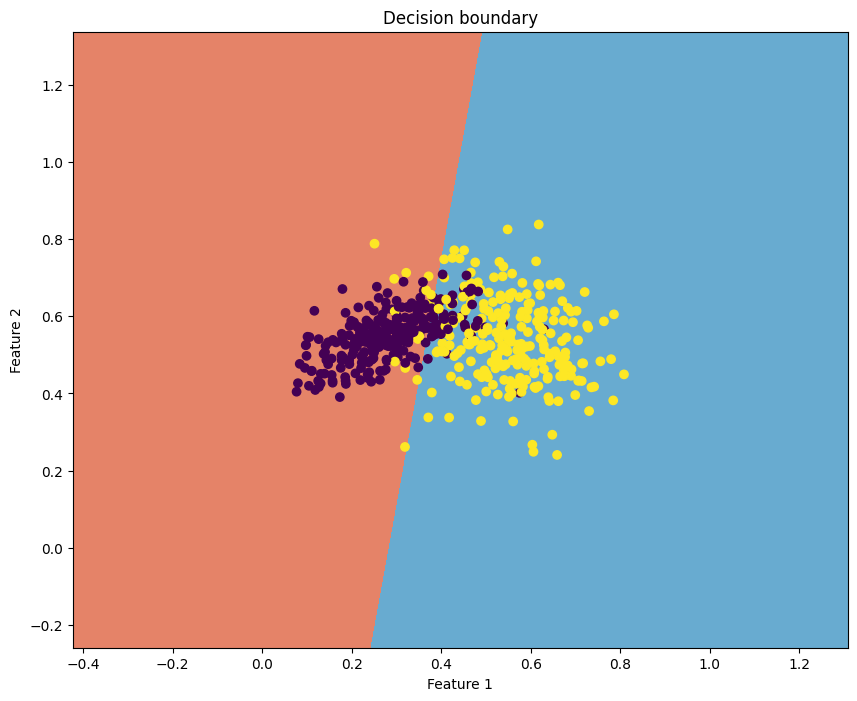

Accuracy: 0.88, Sensivity: 0.94, Specifity: 0.82


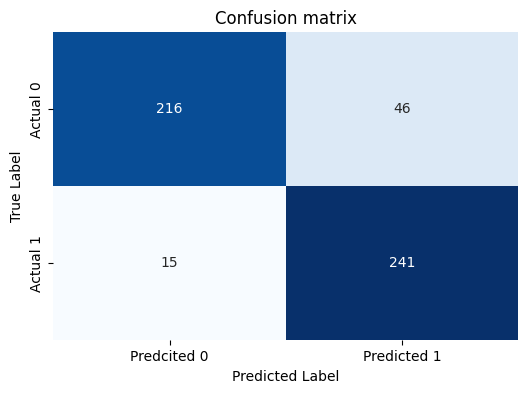

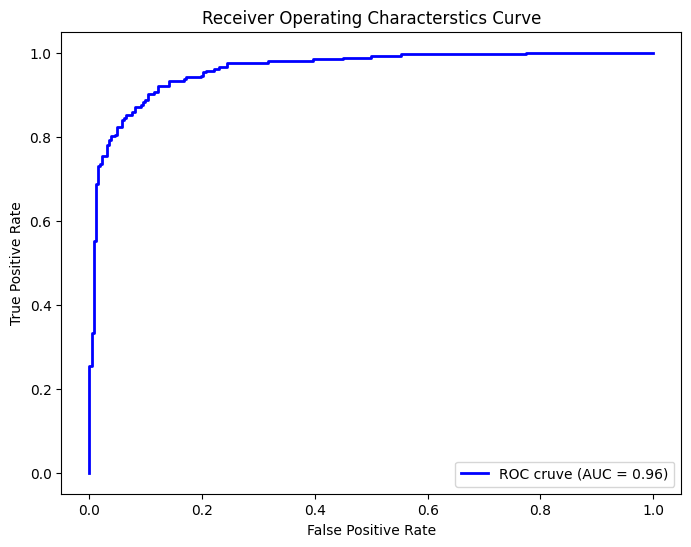

In [160]:
neuron_clf = SingleNeuronModel()
neuron_clf.fit(dataset.X_train, dataset.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset.X_test[:,0].min(), dataset.X_test[:,0].max()
y_min, y_max = dataset.X_test[:,1].min(), dataset.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="RdBu")
plt.scatter(dataset.X_test[:,0], dataset.X_test[:,1], c=dataset.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset.X_test)
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.1.2. Heaviside

Fitting of model took 0.00s


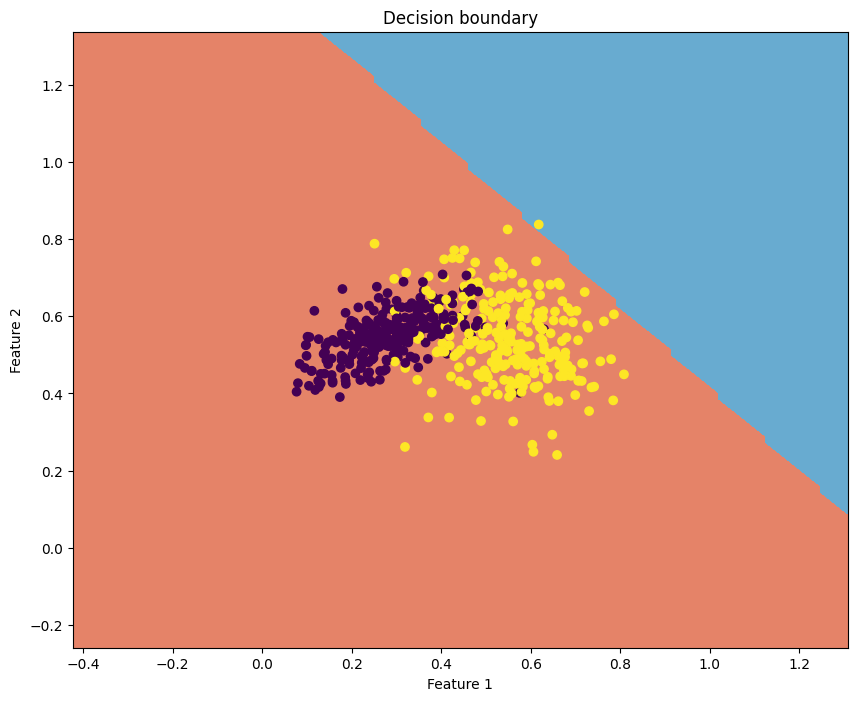

Accuracy: 0.51, Sensivity: 0.00, Specifity: 1.00


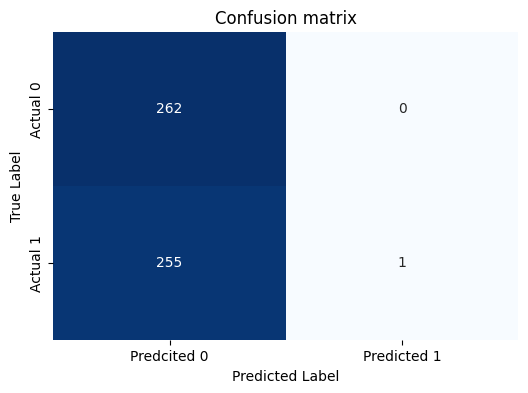

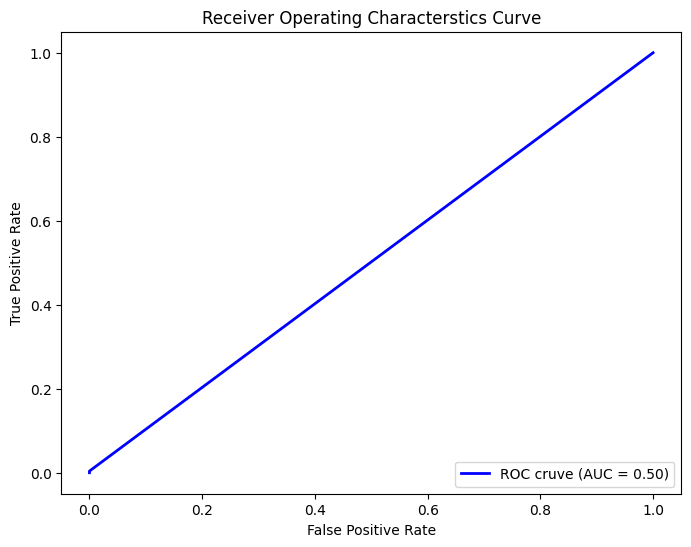

In [161]:
neuron_clf = SingleNeuronModel(activation="Heaviside")
neuron_clf.fit(dataset.X_train, dataset.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset.X_test[:,0].min(), dataset.X_test[:,0].max()
y_min, y_max = dataset.X_test[:,1].min(), dataset.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="RdBu")
plt.scatter(dataset.X_test[:,0], dataset.X_test[:,1], c=dataset.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset.X_test)
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.1.3. Tanh

Fitting of model took 0.00s


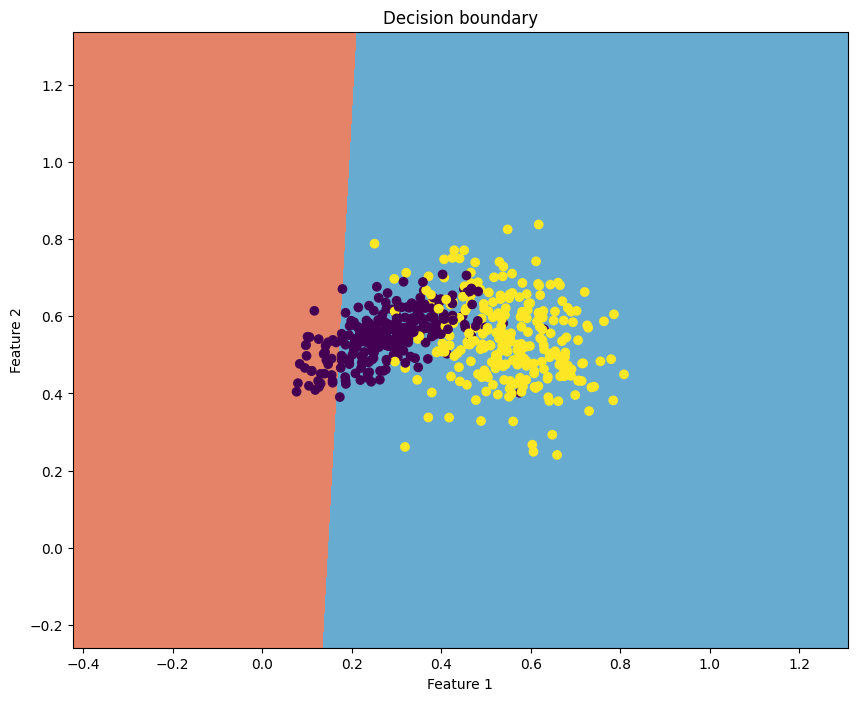

Accuracy: 0.56, Sensivity: 1.00, Specifity: 0.13


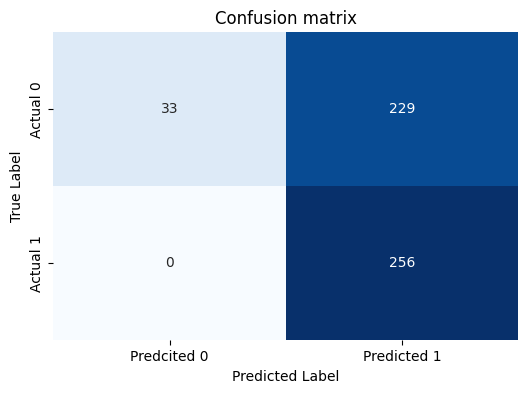

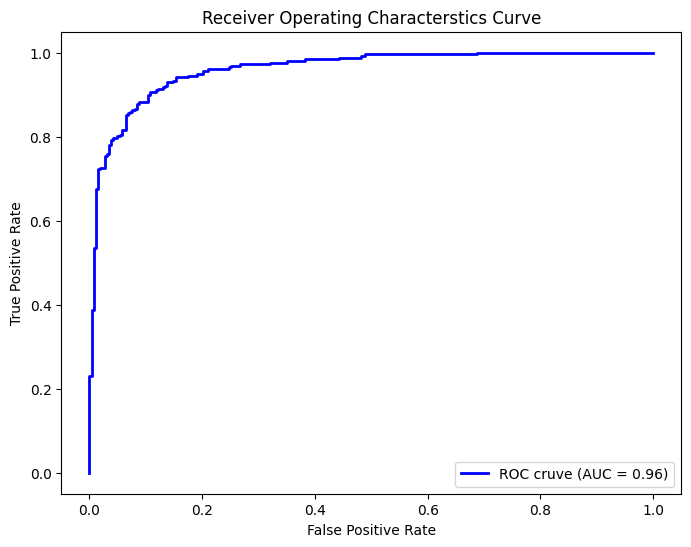

In [162]:
neuron_clf = SingleNeuronModel(activation="tanh")
neuron_clf.fit(dataset.X_train, dataset.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset.X_test[:,0].min(), dataset.X_test[:,0].max()
y_min, y_max = dataset.X_test[:,1].min(), dataset.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="RdBu")
plt.scatter(dataset.X_test[:,0], dataset.X_test[:,1], c=dataset.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset.X_test)
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.1.4. Sign

Fitting of model took 0.00s


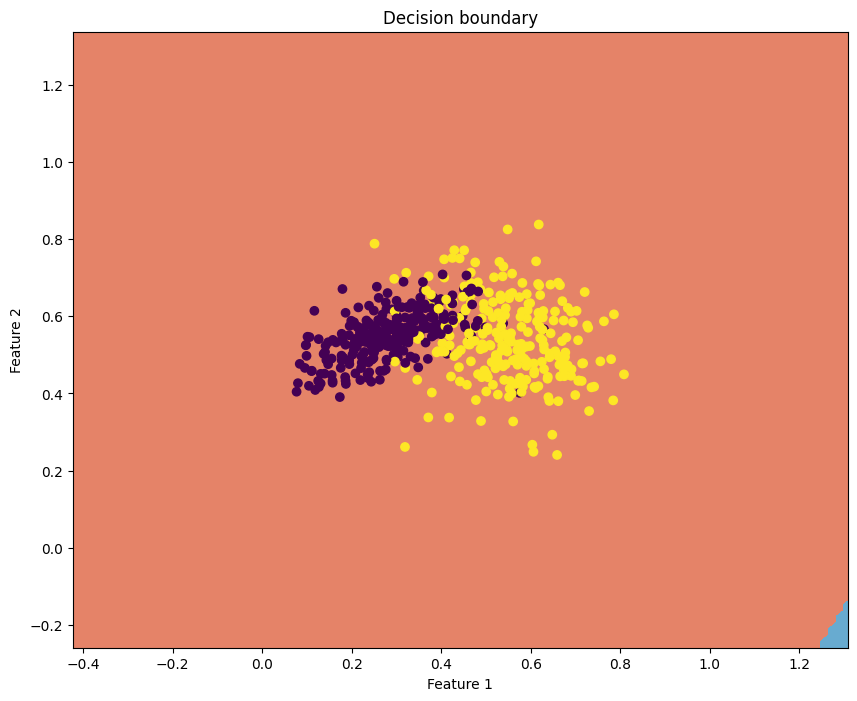

Accuracy: 0.51, Sensivity: 0.00, Specifity: 1.00


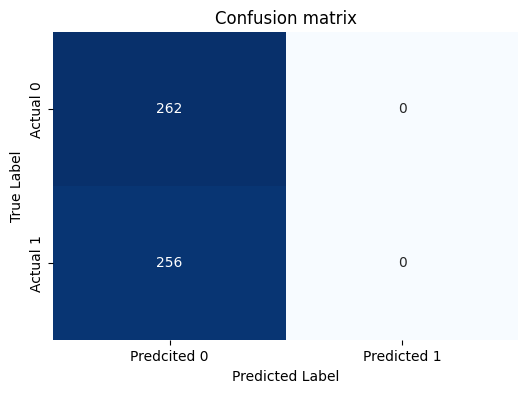

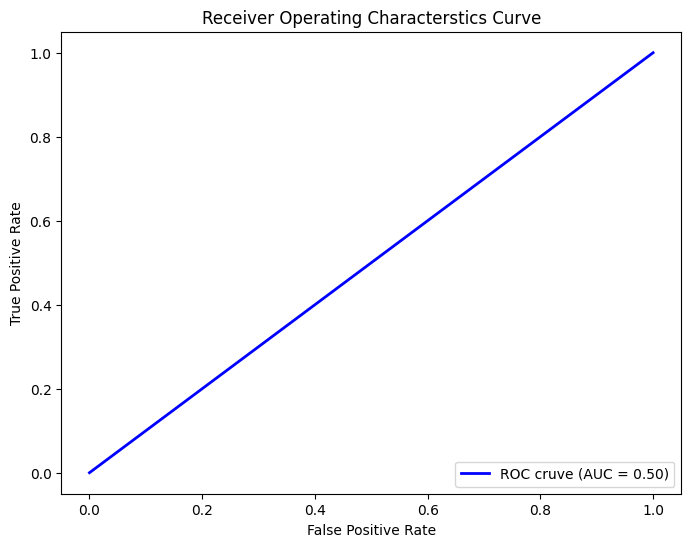

In [163]:
neuron_clf = SingleNeuronModel(activation="sign")
neuron_clf.fit(dataset.X_train, dataset.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset.X_test[:,0].min(), dataset.X_test[:,0].max()
y_min, y_max = dataset.X_test[:,1].min(), dataset.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="RdBu")
plt.scatter(dataset.X_test[:,0], dataset.X_test[:,1], c=dataset.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset.X_test)
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.1.5. Sin

Fitting of model took 0.00s


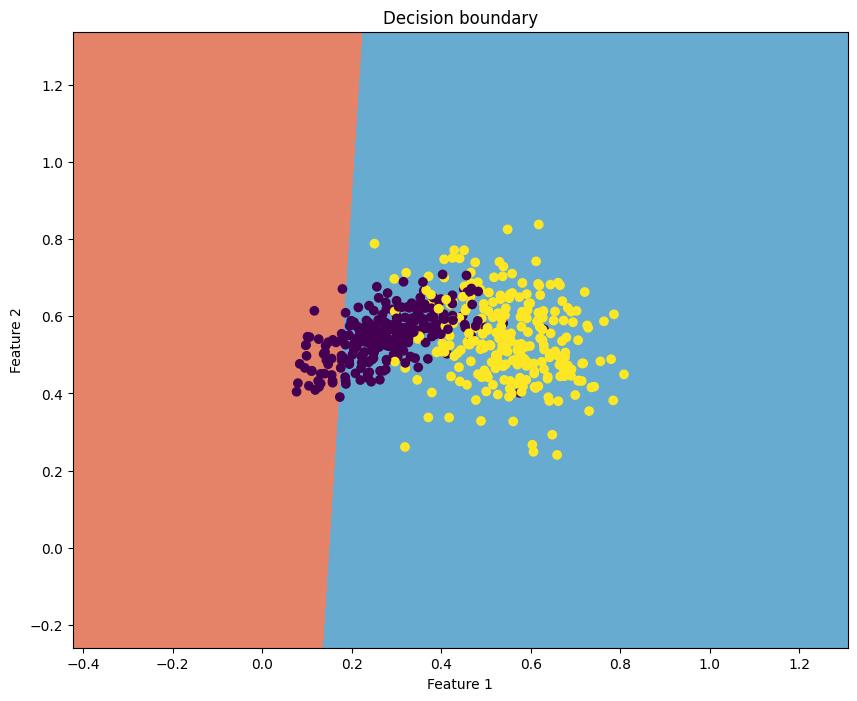

Accuracy: 0.57, Sensivity: 1.00, Specifity: 0.15


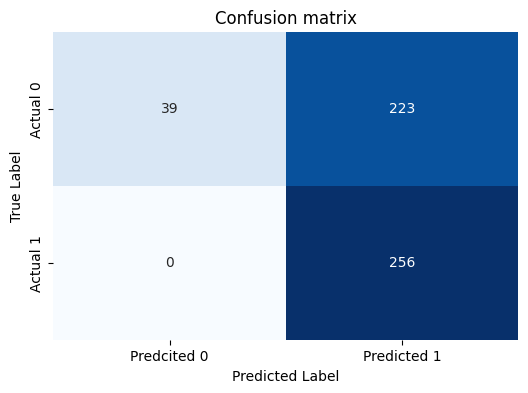

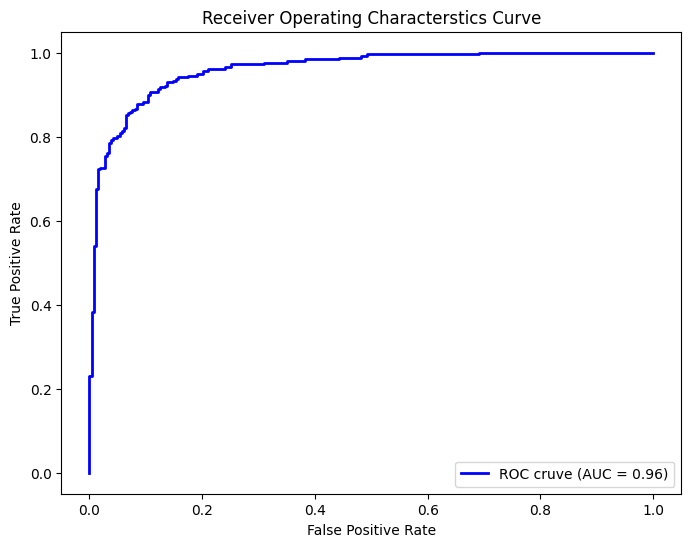

In [164]:
neuron_clf = SingleNeuronModel(activation="sin")
neuron_clf.fit(dataset.X_train, dataset.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset.X_test[:,0].min(), dataset.X_test[:,0].max()
y_min, y_max = dataset.X_test[:,1].min(), dataset.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="RdBu")
plt.scatter(dataset.X_test[:,0], dataset.X_test[:,1], c=dataset.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset.X_test)
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.1.6. ReLu

Fitting of model took 0.00s


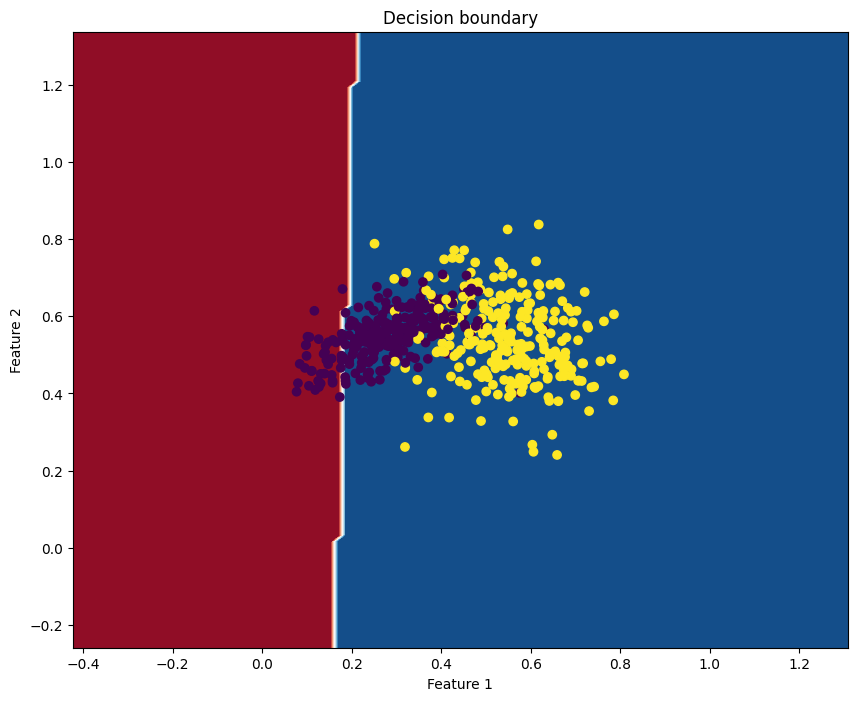

Accuracy: 0.58, Sensivity: 1.00, Specifity: 0.16


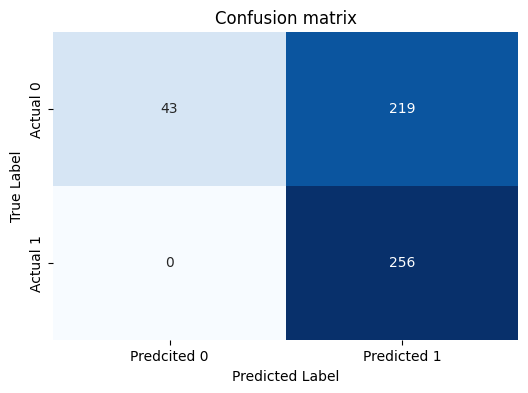

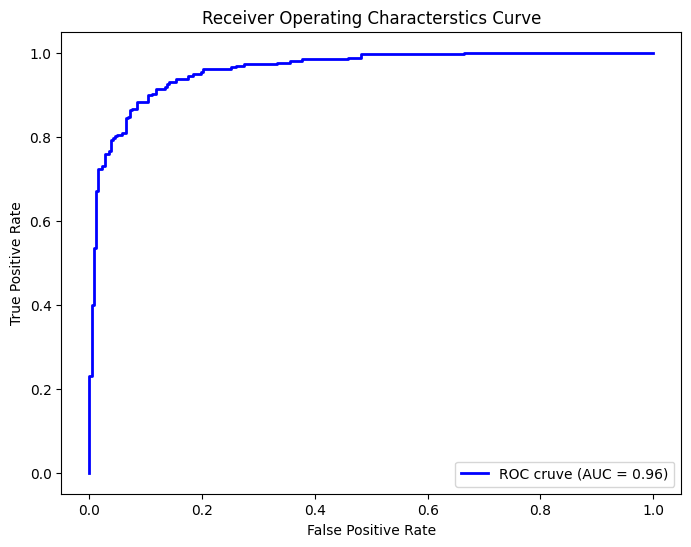

In [165]:
neuron_clf = SingleNeuronModel(activation="ReLu")
neuron_clf.fit(dataset.X_train, dataset.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset.X_test[:,0].min(), dataset.X_test[:,0].max()
y_min, y_max = dataset.X_test[:,1].min(), dataset.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=np.linspace(0.0, np.max(Z), 10), cmap="RdBu")
plt.scatter(dataset.X_test[:,0], dataset.X_test[:,1], c=dataset.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset.X_test)
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.1.7. Leaky ReLu

Fitting of model took 0.00s


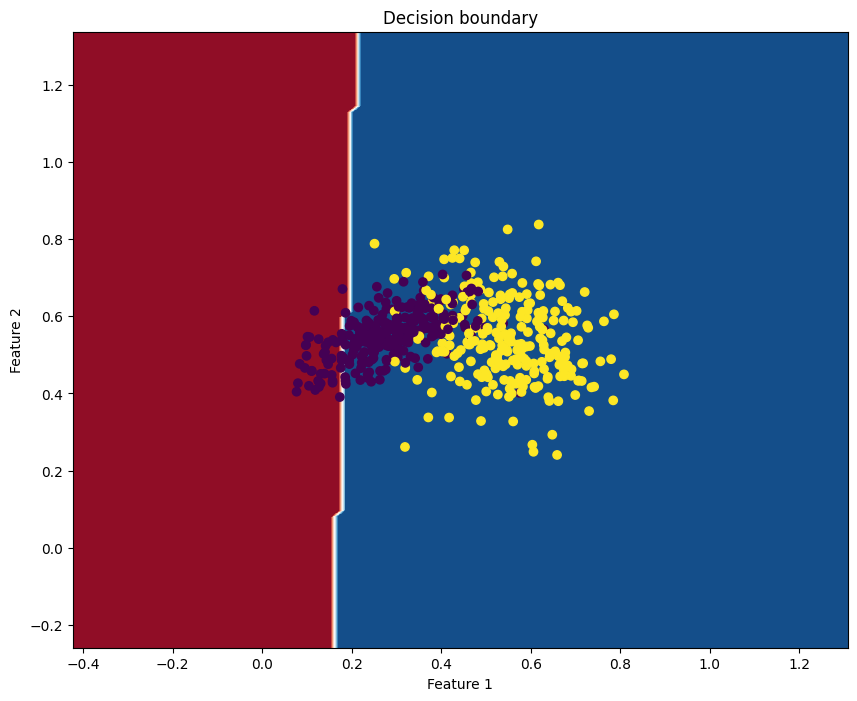

Accuracy: 0.58, Sensivity: 1.00, Specifity: 0.16


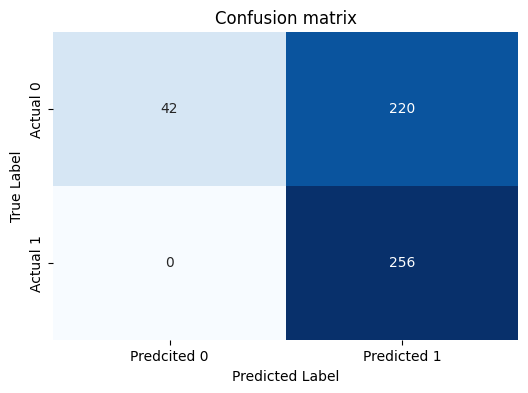

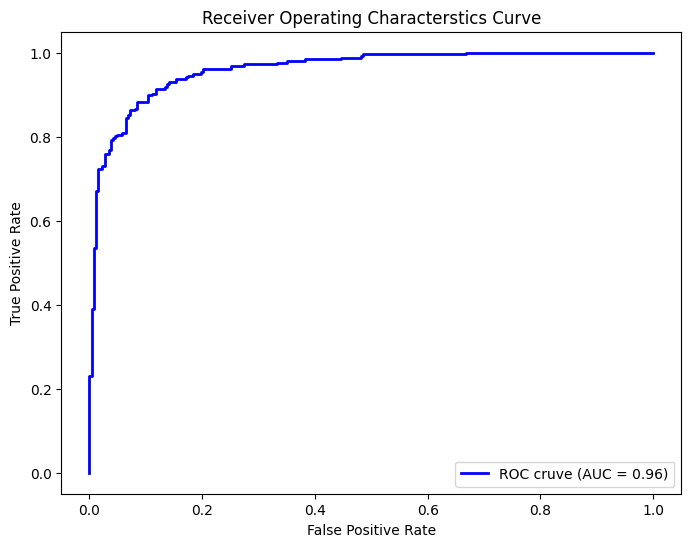

In [166]:
neuron_clf = SingleNeuronModel(activation="leaky ReLu")
neuron_clf.fit(dataset.X_train, dataset.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset.X_test[:,0].min(), dataset.X_test[:,0].max()
y_min, y_max = dataset.X_test[:,1].min(), dataset.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap="RdBu")
plt.scatter(dataset.X_test[:,0], dataset.X_test[:,1], c=dataset.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset.X_test)
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

## 4.2 Make moons

### 4.2.1 Logistic

Fitting of model took 0.00s


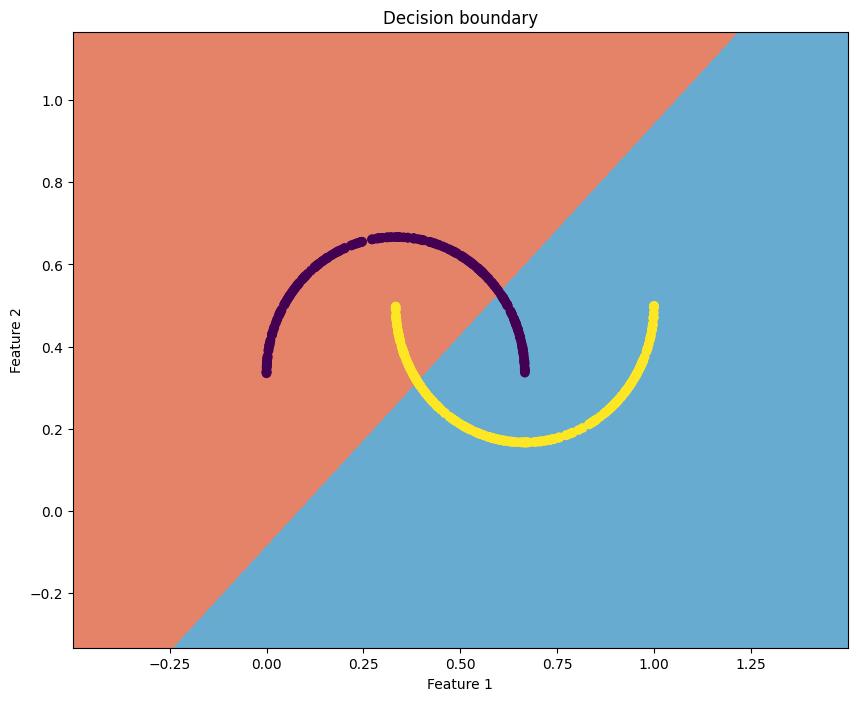

Accuracy: 0.79, Sensivity: 0.81, Specifity: 0.78


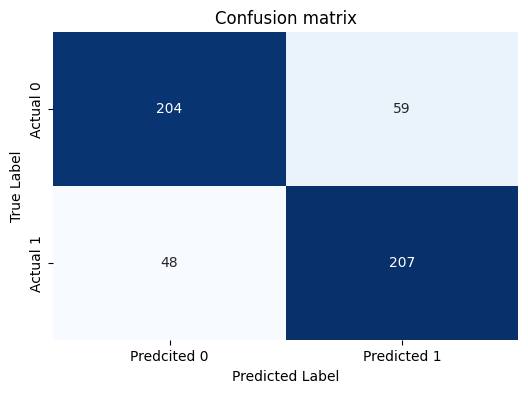

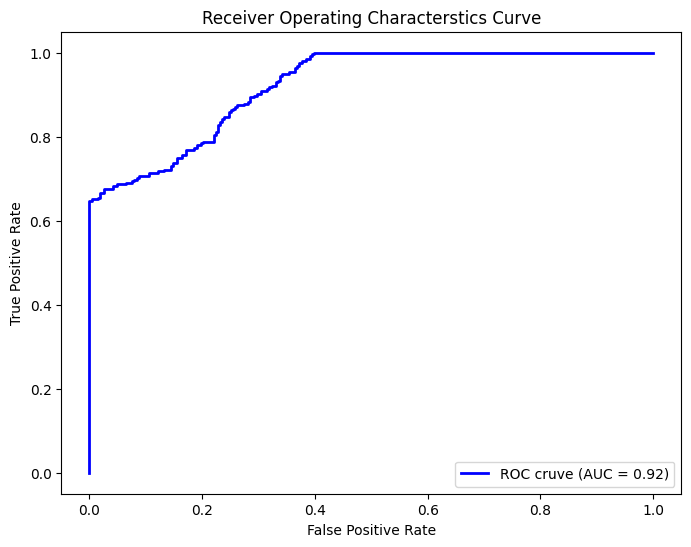

In [167]:
neuron_clf = SingleNeuronModel()
neuron_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset_moons.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset_moons.X_test[:,0].min(), dataset_moons.X_test[:,0].max()
y_min, y_max = dataset_moons.X_test[:,1].min(), dataset_moons.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="RdBu")
plt.scatter(dataset_moons.X_test[:,0], dataset_moons.X_test[:,1], c=dataset_moons.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset_moons.X_test)
fpr, tpr, thresholds = roc_curve(dataset_moons.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.2.2. Heaviside

Fitting of model took 0.00s


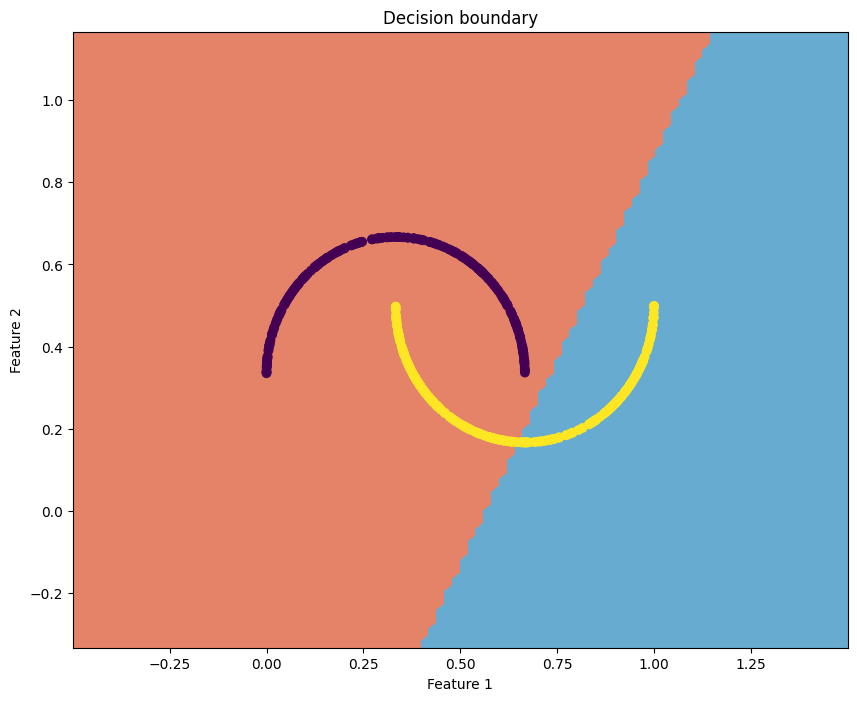

Accuracy: 0.75, Sensivity: 0.50, Specifity: 1.00


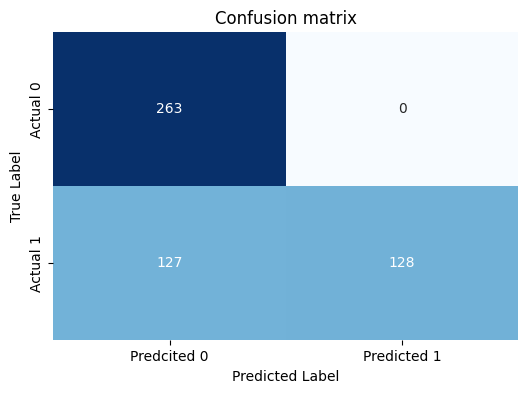

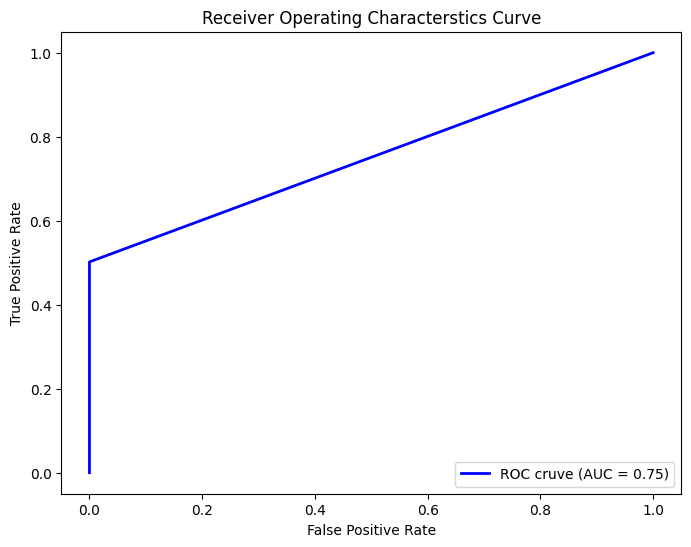

In [168]:
neuron_clf = SingleNeuronModel(activation="Heaviside")
neuron_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset_moons.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset_moons.X_test[:,0].min(), dataset_moons.X_test[:,0].max()
y_min, y_max = dataset_moons.X_test[:,1].min(), dataset_moons.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="RdBu")
plt.scatter(dataset_moons.X_test[:,0], dataset_moons.X_test[:,1], c=dataset_moons.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset_moons.X_test)
fpr, tpr, thresholds = roc_curve(dataset_moons.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.2.3. Tanh

Fitting of model took 0.00s


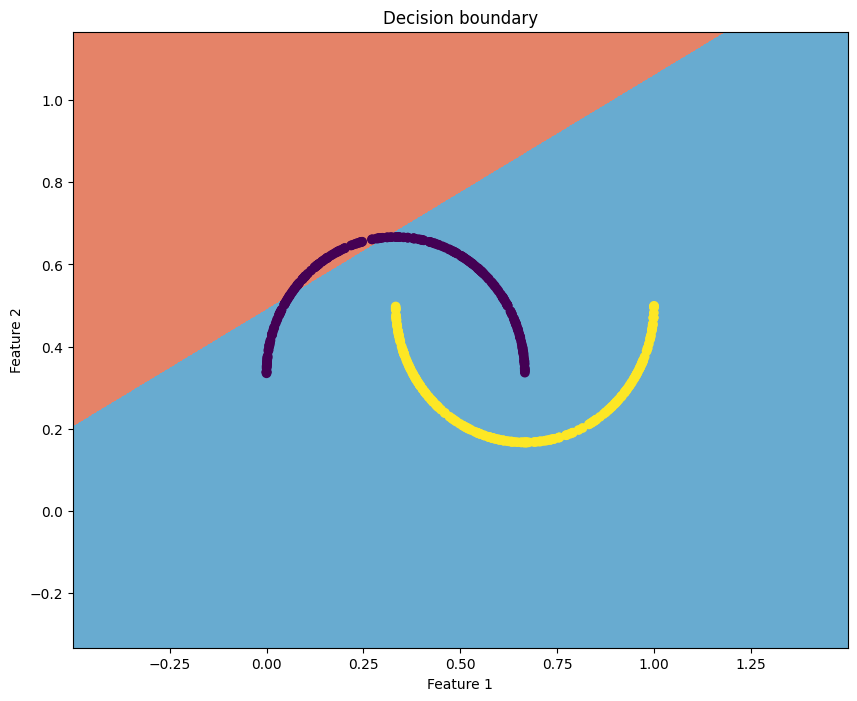

Accuracy: 0.63, Sensivity: 1.00, Specifity: 0.28


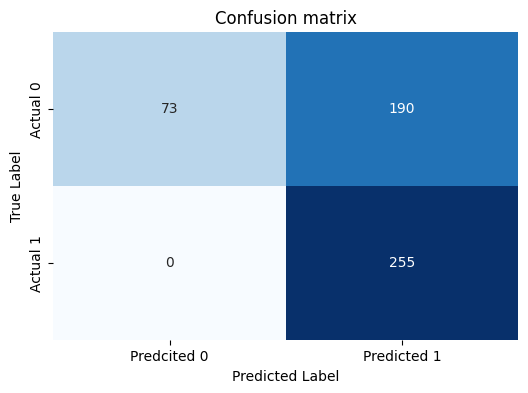

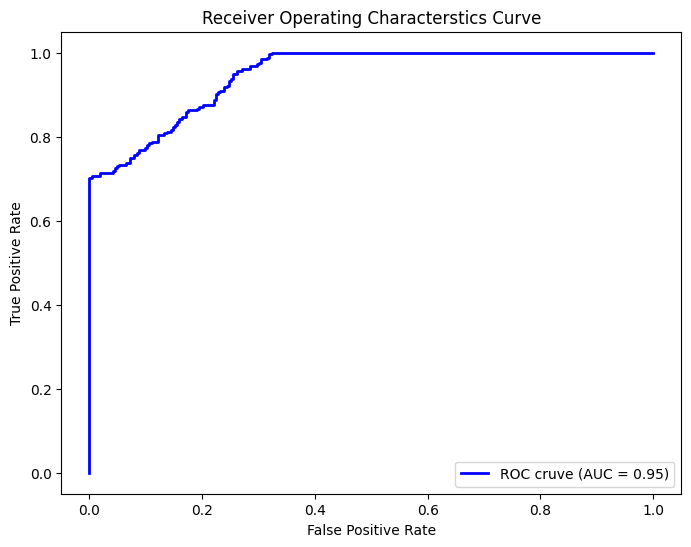

In [169]:
neuron_clf = SingleNeuronModel(activation="tanh")
neuron_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset_moons.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset_moons.X_test[:,0].min(), dataset_moons.X_test[:,0].max()
y_min, y_max = dataset_moons.X_test[:,1].min(), dataset_moons.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="RdBu")
plt.scatter(dataset_moons.X_test[:,0], dataset_moons.X_test[:,1], c=dataset_moons.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset_moons.X_test)
fpr, tpr, thresholds = roc_curve(dataset_moons.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.2.4. Sign

Fitting of model took 0.00s


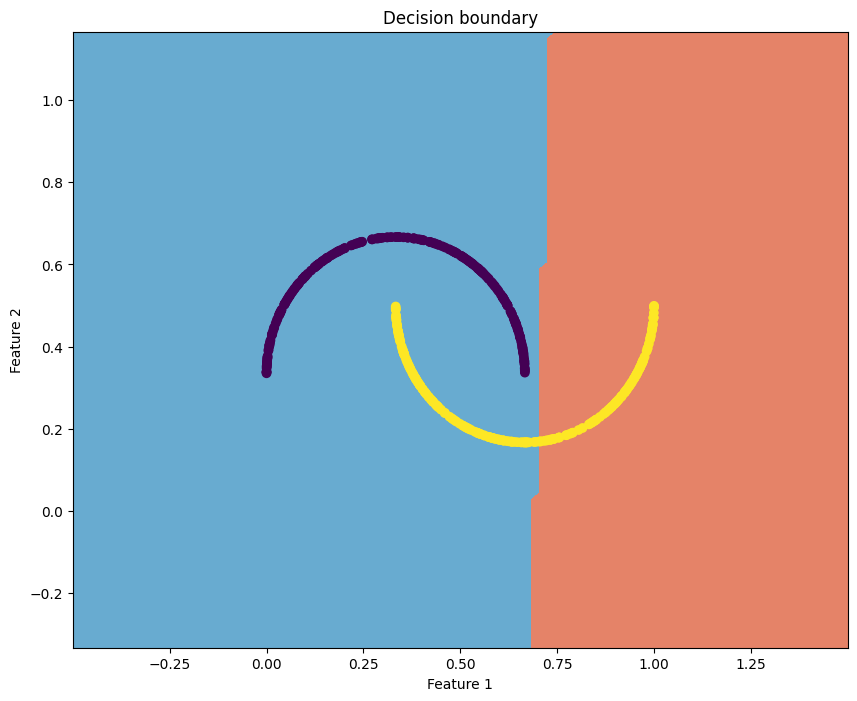

Accuracy: 0.50, Sensivity: 0.97, Specifity: 0.04


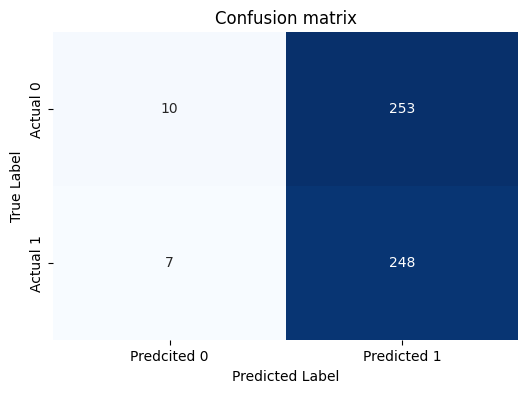

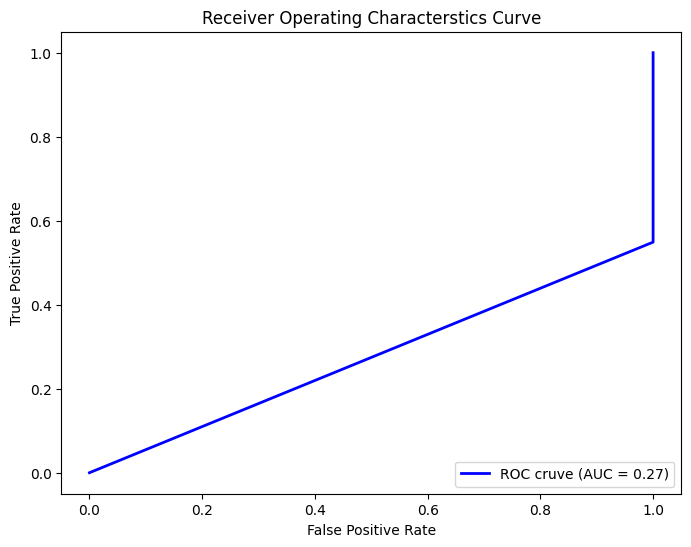

In [170]:
neuron_clf = SingleNeuronModel(activation="sign")
neuron_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset_moons.X_test[:,0].min(), dataset_moons.X_test[:,0].max()
y_min, y_max = dataset_moons.X_test[:,1].min(), dataset_moons.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="RdBu")
plt.scatter(dataset_moons.X_test[:,0], dataset_moons.X_test[:,1], c=dataset_moons.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset_moons.X_test)
fpr, tpr, thresholds = roc_curve(dataset_moons.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.2.5. Sin

Fitting of model took 0.00s


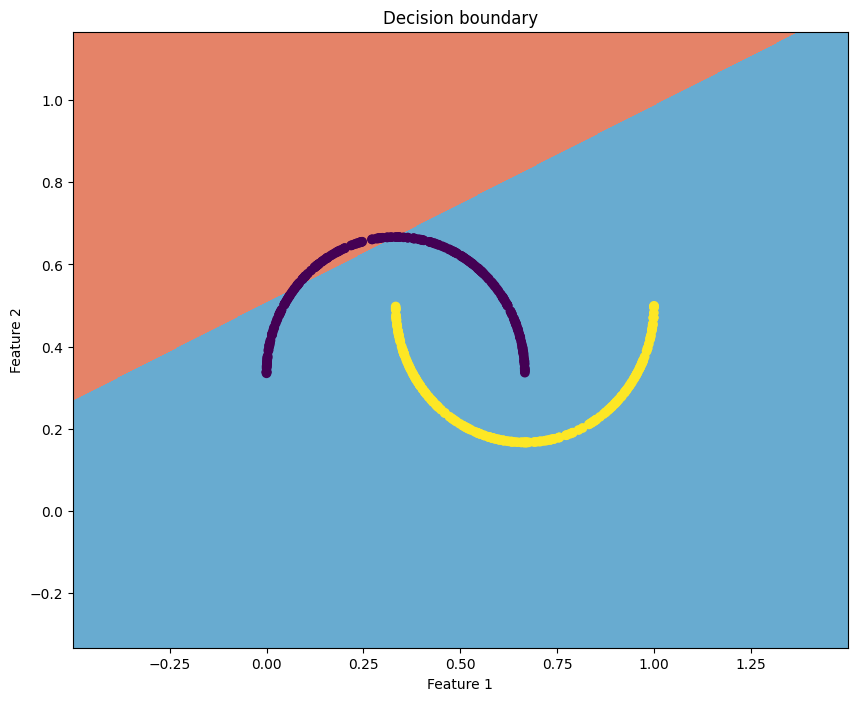

Accuracy: 0.63, Sensivity: 1.00, Specifity: 0.27


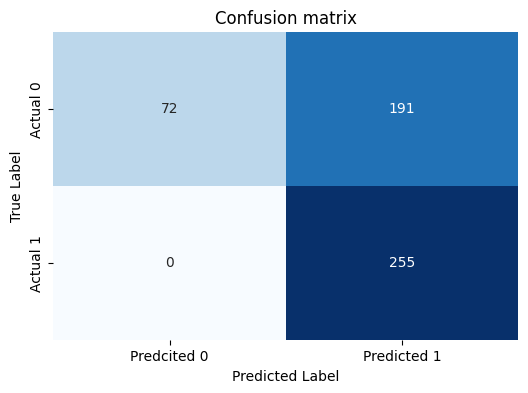

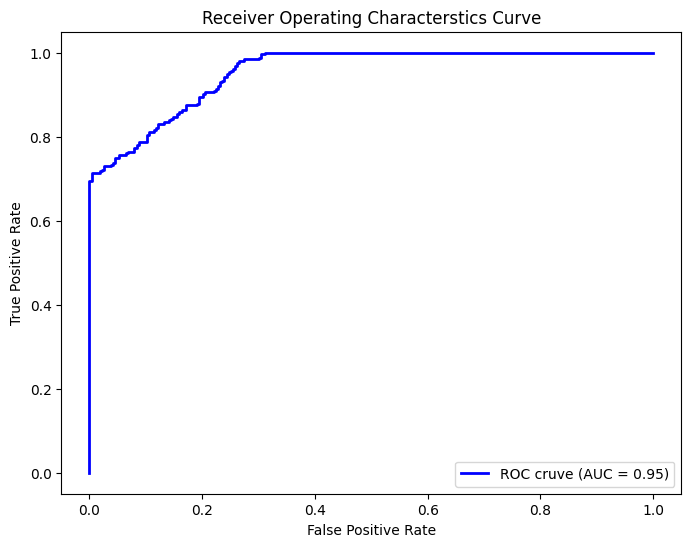

In [171]:
neuron_clf = SingleNeuronModel(activation="sin")
neuron_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset_moons.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset_moons.X_test[:,0].min(), dataset_moons.X_test[:,0].max()
y_min, y_max = dataset_moons.X_test[:,1].min(), dataset_moons.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="RdBu")
plt.scatter(dataset_moons.X_test[:,0], dataset_moons.X_test[:,1], c=dataset_moons.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset_moons.X_test)
fpr, tpr, thresholds = roc_curve(dataset_moons.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.2.6. ReLu

Fitting of model took 0.00s


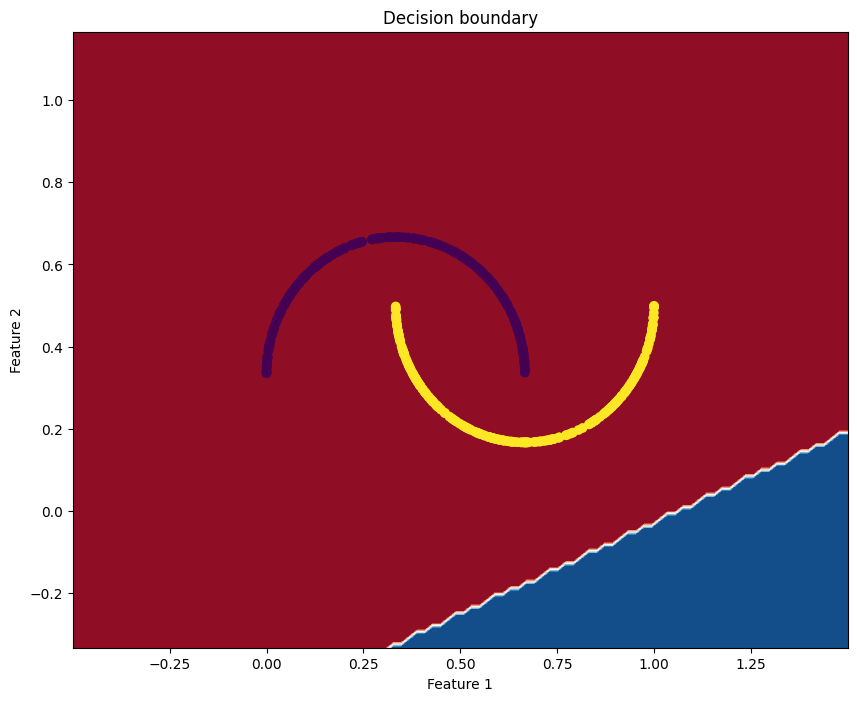

Accuracy: 0.51, Sensivity: 0.00, Specifity: 1.00


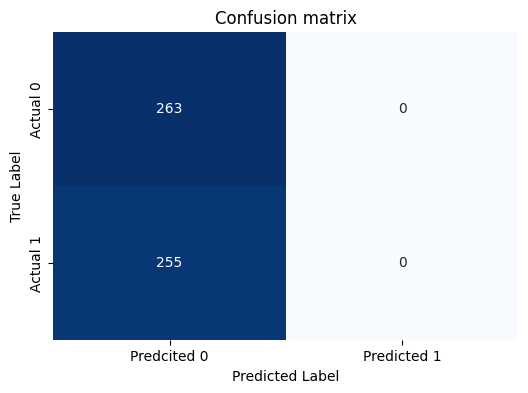

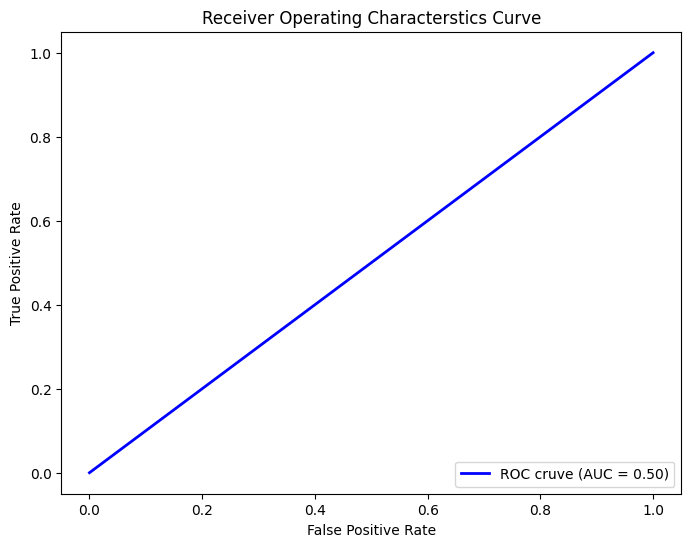

In [172]:
neuron_clf = SingleNeuronModel(activation="ReLu")
neuron_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset_moons.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset_moons.X_test[:,0].min(), dataset_moons.X_test[:,0].max()
y_min, y_max = dataset_moons.X_test[:,1].min(), dataset_moons.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=np.linspace(0, np.max(Z), 10), cmap="RdBu")
plt.scatter(dataset_moons.X_test[:,0], dataset_moons.X_test[:,1], c=dataset_moons.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset_moons.X_test)
fpr, tpr, thresholds = roc_curve(dataset_moons.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)

### 4.2.7. Leaky ReLu

Fitting of model took 0.00s


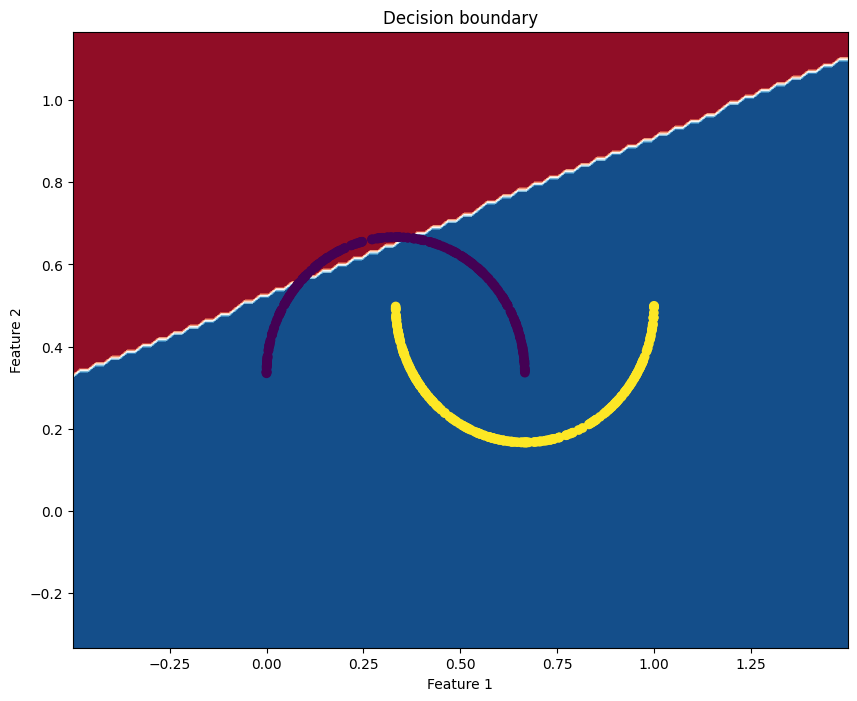

Accuracy: 0.63, Sensivity: 1.00, Specifity: 0.28


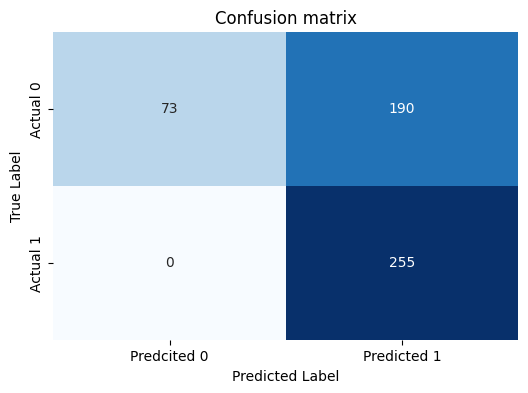

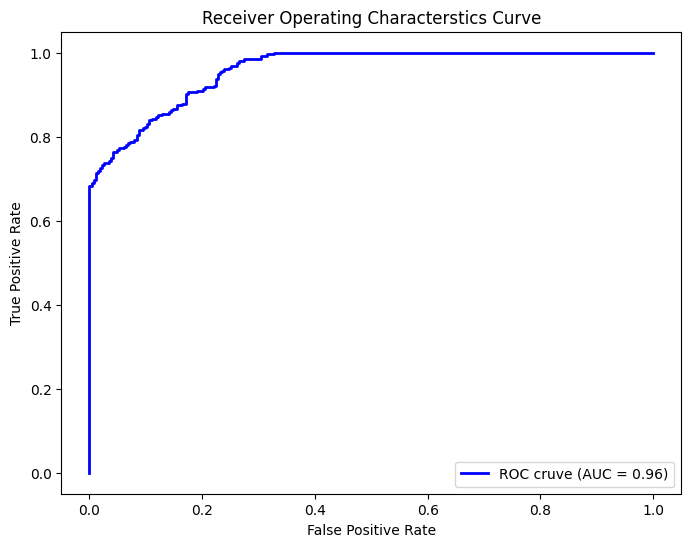

In [173]:
neuron_clf = SingleNeuronModel(activation="leaky ReLu")
neuron_clf.fit(dataset_moons.X_train, dataset_moons.y_train)

# Computing time 
start_time = time.time()

for _ in range(100):

    y_pred = neuron_clf.predict(dataset_moons.X_test)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Fitting of model took {elapsed_time:.2f}s")

# Creating meshgrid
x_min, x_max = dataset_moons.X_test[:,0].min(), dataset_moons.X_test[:,0].max()
y_min, y_max = dataset_moons.X_test[:,1].min(), dataset_moons.X_test[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min - 0.5, x_max + 0.5, 100), np.linspace(y_min + - 0.5, y_max + 0.5, 100))
Z = neuron_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap="RdBu")
plt.scatter(dataset_moons.X_test[:,0], dataset_moons.X_test[:,1], c=dataset_moons.y_test)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision boundary")
plt.show()

y_pred_proba = neuron_clf.predict_proba(dataset_moons.X_test)
fpr, tpr, thresholds = roc_curve(dataset_moons.y_test, y_pred_proba)

# Results for own 
analyzer = ResultsAnalyzes(dataset_moons.y_test, y_pred)
analyzer.show_results()
analyzer.confusion_matrix()
analyzer.plot_ROC_curve(y_pred_proba)